# Forecasting Enrollment
The point of this notebook it to teach the reader, you, how to use the code residing inside this code base. We will walk you through how to add your data, what form the data should be in, and the different models you can use to predict the next quarter using the data you provide

## I. Import libraries needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools
import csv
from itertools import product

## II. Load the data and data preprocessing

### a. loading those helper function for curation data step


*   **format_time**: process the float time into String type
*   **term_to_datetime**: from the term given, process to get datetime object
*   **decode_terms** : maping from numerical coding to string format
*   **visualization_curation** : visulize curation
*   **preprocess_days:**: transform the day information into a binary format
*   **drop_unnecessary** : Drop unnecessary columns and filter out small enrollment courses
*   **split_term_year**: Separate the TERM column into distinct YEAR and TERM columns.
*   **calculate_preference_last_year**: Compute the preference as the average enrollment of the same course from the previous year.
*   **encode_categorical_features**: One-hot encode categorical features
*   **filter_csci_courses**: Filter the dataset to include only computer science-related courses.
*   **add_core_course_indicator**: Mark core courses based on predefined core values
*   **encode_class_days**: Combine day indicators into a single feature and encode unique day combinations
*   **process_begin_time**: Convert start time to numerical format and apply time encoding







In [2]:
# Make time columns readable and datetime objects
def format_time(time_float):
    time_str = f"{int(time_float // 100):02d}:{int(time_float % 100):02d}"
    return time_str

# by the term, you are getting a start date of each quarter
def term_to_datetime(term):
    # Add start date column (estimated)
    quarter_start_dates = {
    'Winter': '01-03',
    'Spring': '03-14',
    'Summer': '06-15',
    'Fall': '09-01'
    }
    try:
        quarter, year = term.split()
        date_str = f"{year}-{quarter_start_dates[quarter]}"
        return pd.to_datetime(date_str)
    except Exception as e:
        print(f"Error converting term '{term}': {e}")
        return pd.NaT
def decode_terms(term):
        # Make term column readable by mapping from numerical coding to string format
    quarter_map = {
        '10': 'Winter',
        '20': 'Spring',
        '30': 'Summer',
        '40': 'Fall'
    }
    year = term[:4]
    quarter = term[4:]
    quarter = quarter_map.get(quarter, 'Unknown')
    return f"{quarter} {year}"

def visualization_curation(enrollment_data):

    # Decode begin time and end time
    enrollment_data['PRIMARY_BEGIN_TIME'] = enrollment_data['PRIMARY_BEGIN_TIME'].apply(lambda x: format_time(x) if not pd.isna(x) else x)
    enrollment_data['PRIMARY_END_TIME'] = enrollment_data['PRIMARY_END_TIME'].apply(lambda x: format_time(x) if not pd.isna(x) else x)

    enrollment_data['PRIMARY_BEGIN_TIME'] = pd.to_datetime(enrollment_data['PRIMARY_BEGIN_TIME'], format='%H:%M').dt.time
    enrollment_data['PRIMARY_END_TIME'] = pd.to_datetime(enrollment_data['PRIMARY_END_TIME'], format='%H:%M').dt.time

    # decode terms
    enrollment_data['TERM'] = enrollment_data['TERM'].astype(str).apply(decode_terms)

    # decode from term we are getting a start date of each quarter
    enrollment_data['Start_Date'] = enrollment_data['TERM'].astype(str).apply(term_to_datetime)
    return enrollment_data


#Convert days columns to binary indicators (1 if class is scheduled, 0 otherwise).
def preprocess_days(enrollment_data):
    date_cols = ['U', 'M', 'T', 'W', 'R', 'F', 'S']
    enrollment_data[date_cols] = enrollment_data[date_cols].fillna(0)
    enrollment_data[date_cols] = enrollment_data[date_cols].applymap(lambda x: 1 if x != 0 else 0)
    return enrollment_data

# Drop unnecessary columns and filter out small enrollment courses
def drop_unnecessary(enrollment_data):
    enrollment_data = enrollment_data.drop(columns=['TITLE', 'PRIMARY_END_TIME', 'Start_Date'])
    return enrollment_data[enrollment_data['ACTUAL_ENROLL'] > 10]

# Separate the TERM column into distinct YEAR and TERM columns.
def split_term_year(enrollment_data):
    enrollment_data['YEAR'] = enrollment_data['TERM'].str.split().str[-1]
    enrollment_data['TERM'] = enrollment_data['TERM'].str.split().str[0]
    return enrollment_data

# Compute the preference as the average enrollment of the same course from the previous year.
def calculate_preference_last_year(enrollment_data):
    enrollment_data['YEAR_INT'] = enrollment_data['YEAR'].astype(int)
    min_year = enrollment_data['YEAR_INT'].min()
    enrollment_data['PREFERENCE_LAST_YEAR'] = enrollment_data.apply(
        lambda row: enrollment_data[
            (enrollment_data['YEAR_INT'] == row['YEAR_INT'] - 1) &
            (enrollment_data['COURSE_NUMBER'] == row['COURSE_NUMBER'])
        ]['ACTUAL_ENROLL'].mean() if row['YEAR_INT'] > min_year else row['ACTUAL_ENROLL'], axis=1
    )
    return enrollment_data.drop(columns=['YEAR_INT'])
# One-hot encode categorical features
def encode_categorical_features(enrollment_data):
    categorical_columns = ['TERM', 'YEAR', 'CAMPUS', 'PRIMARY_INSTRUCTOR_TENURE_CODE','CAPENROLL']
    enrollment_data = pd.get_dummies(enrollment_data, columns=categorical_columns)
    return enrollment_data
# Filter the dataset to include only computer science-related courses.
def filter_csci_courses(enrollment_data):
    csci_adj = ['CSCI', 'CISS', 'DATA']
    return enrollment_data[enrollment_data['SUBJECT'].isin(csci_adj)]

# Mark core courses based on predefined core values
def add_core_course_indicator(csci_data):
    core_values = {"141", "145", "241", "247", "301"}
    csci_data['COURSE_NUMBER_STR'] = csci_data['COURSE_NUMBER'].astype(str)
    csci_data['CORE'] = csci_data['COURSE_NUMBER_STR'].apply(lambda x: 1 if x in core_values else 0)
    return csci_data.drop(columns=['COURSE_NUMBER_STR'])

#Combine day indicators into a single feature and encode unique day combinations.
def encode_class_days(csci_data):
    date_cols = ['U', 'M', 'T', 'W', 'R', 'F', 'S']

    def day_combinations(row):
        return ''.join([day for day, present in zip(date_cols, row) if present == 1])

    csci_data['DATE_COMBINATION'] = csci_data[date_cols].apply(day_combinations, axis=1)
    for combination in csci_data['DATE_COMBINATION'].unique():
        csci_data[combination] = csci_data['DATE_COMBINATION'].apply(lambda x: 1 if x == combination else 0)

    return csci_data.drop(columns=['DATE_COMBINATION'])

#Convert start time to numerical format and apply time encoding
def process_begin_time(csci_data):
    csci_data['PRIMARY_BEGIN_TIME'] = pd.to_datetime(csci_data['PRIMARY_BEGIN_TIME'], format='%H:%M:%S', errors='coerce')
    csci_data['BEGIN_TIME_MINUTES'] = csci_data['PRIMARY_BEGIN_TIME'].dt.hour * 60 + csci_data['PRIMARY_BEGIN_TIME'].dt.minute

    # Fill missing values with mean
    mean_minutes = csci_data['BEGIN_TIME_MINUTES'].mean()
    csci_data['BEGIN_TIME_MINUTES'].fillna(mean_minutes, inplace=True)

    # Normalize time and encode as sine/cosine
    csci_data['BEGIN_TIME_MINUTES'] = csci_data['BEGIN_TIME_MINUTES'] / 60
    csci_data['sin_time'] = np.sin(csci_data['BEGIN_TIME_MINUTES'] * (np.pi / 24))
    csci_data['cos_time'] = np.cos(csci_data['BEGIN_TIME_MINUTES'] * (np.pi / 24))

    return csci_data.drop(columns=['PRIMARY_BEGIN_TIME'])
def remove_invalid_course_numbers(df, column='COURSE_NUMBER'):

    df = df.copy()
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df_cleaned = df.dropna(subset=[column])
    df_cleaned[column] = df_cleaned[column].astype(int)

    return df_cleaned

### b. Load data and preprocessing
base_data will be given through github. Please nake sure you add it to directory before run the cell code below

In [134]:
def preprocessing(enrollment_data):

    enrollment_data = preprocess_days(enrollment_data)
    enrollment_data = drop_unnecessary(enrollment_data)
    enrollment_data = split_term_year(enrollment_data)
    # enrollment_data = calculate_preference_last_year(enrollment_data)
    enrollment_data = encode_categorical_features(enrollment_data)

    csci_data = filter_csci_courses(enrollment_data)
    csci_data = add_core_course_indicator(csci_data)
    csci_data = encode_class_days(csci_data)

    csci_data = csci_data.dropna(subset=['PRIMARY_BEGIN_TIME'])
    csci_data = process_begin_time(csci_data)
    csci_data = csci_data.drop(columns=['SUBJECT', 'CRN'])
    csci_data = remove_invalid_course_numbers(csci_data)
    csci_data = csci_data.drop(columns=['BEGIN_TIME_MINUTES'])
    return csci_data.dropna()

raw_dataset = pd.read_csv('base_data.csv')
ml_dataset = preprocessing(raw_dataset)
ml_dataset
# if you wanna save it to csv file
#ml_dataset.to_csv('machine_learning_data.csv', index=False)

<ipython-input-2-49d48ae24663>:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  enrollment_data[date_cols] = enrollment_data[date_cols].applymap(lambda x: 1 if x != 0 else 0)
<ipython-input-2-49d48ae24663>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csci_data['COURSE_NUMBER_STR'] = csci_data['COURSE_NUMBER'].astype(str)
<ipython-input-2-49d48ae24663>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csci_data['CORE'] = csci_data['COURSE_NUMBER_STR'].apply(lambda 

,COURSE_NUMBER,ACTUAL_ENROLL,U,M,T,W,R,F,S,TERM_Fall,...,TWR,MT,MTF,MTRF,WRF,TW,WR,WF,sin_time,cos_time
7,101,13,0,0,0,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.923880,3.826834e-01
17,102,18,0,0,0,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.991445,-1.305262e-01
30,140,25,0,0,0,0,0,0,0,True,...,0,0,0,0,0,0,0,0,0.866025,5.000000e-01
76,141,25,0,0,0,0,0,0,0,True,...,0,0,0,0,0,0,0,0,1.000000,6.123234e-17
79,301,20,0,0,0,0,0,0,0,True,...,0,0,0,0,0,0,0,0,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112568,247,18,0,0,0,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.965926,2.588190e-01
112601,301,20,0,0,0,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.991445,1.305262e-01
112623,591,21,0,0,1,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.866025,-5.000000e-01
112730,347,21,0,0,0,0,0,0,0,False,...,0,0,0,0,0,0,0,0,0.923880,3.826834e-01


## III. Explorring distribution

### a. Some helper method


*   plot_distribution: input dataset and column name -> distribution of the feature
*   plot_enroll_comparison: compare two group with threshold



In [11]:
def plot_distribution(df, column='ACTUAL_ENROLL', bins=30, label_rotation=45):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(df[column], bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

    # Rotate x-axis tick labels by the specified angle
    ax.tick_params(axis='x', labelrotation=label_rotation)

    plt.tight_layout()
    plt.show()

def plot_enroll_comparison(df, column='ACTUAL_ENROLL', threshold=20, bins=30, label_rotation=45):

    # Filter data into two groups
    group1_count = df[df[column] <= threshold].shape[0]
    group2_count = df[df[column] > threshold].shape[0]

    # Create labels and counts for the two groups
    groups = [f"{column} <= {threshold}", f"{column} > {threshold}"]
    counts = [group1_count, group2_count]

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(groups, counts, color=['blue', 'red'], edgecolor='black')
    ax.set_title(f"Count Comparison of {column} Groups")
    ax.set_ylabel("Number of Records")

    # Rotate the x-axis tick labels by the specified angle
    ax.tick_params(axis='x', labelrotation=label_rotation)

    # Annotate the bars with count values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset in points
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



### b. Distribution of predicted value.
There are many class such as 141, 241, 301 and 241 have 20 student per class that make sense the number of actual_enrol = 20 have significant different from the rest.
There are many course like 490 491 having just 1 section so that why it go up to around 80 in the past.

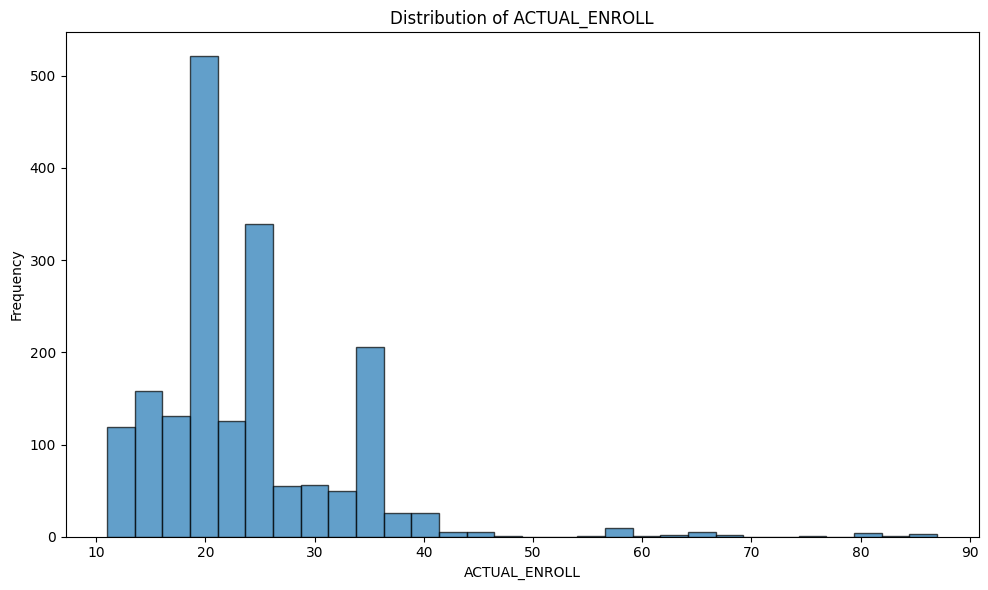

In [12]:
column_name =  'ACTUAL_ENROLL'
bins = 30
plot_distribution(ml_dataset, column = column_name , bins = bins, label_rotation = 0)

### c. What class having the ACTUAL_ENROLL = 20

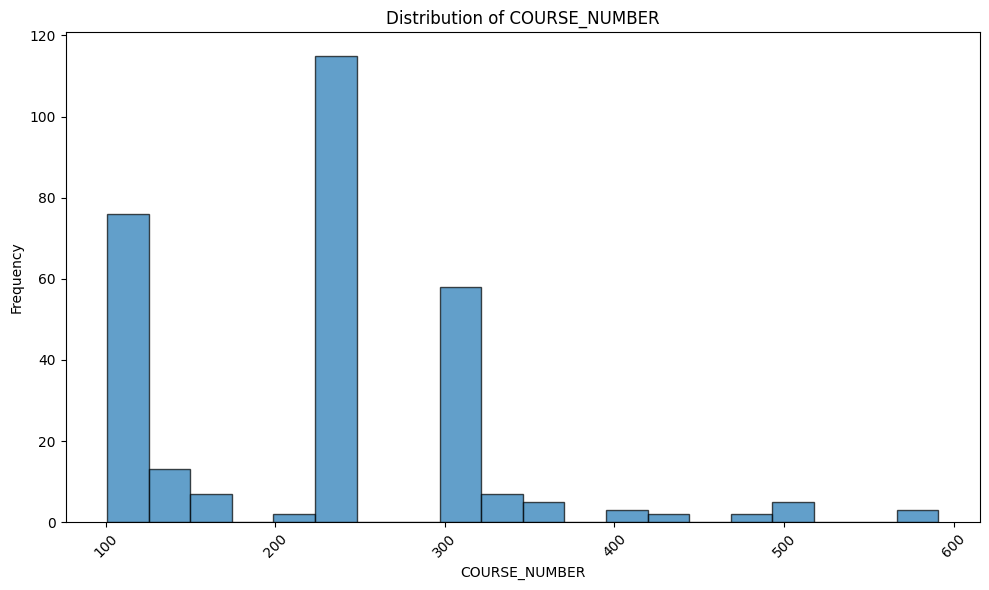

In [137]:
column_name =  'COURSE_NUMBER'
bins = 20
actual_enroll = 20
filtered_df = ml_dataset[ml_dataset['ACTUAL_ENROLL'] == actual_enroll]
plot_distribution(filtered_df, column = column_name , bins = bins)

### d. What class having more than some threshold and comparing?
For example, what class having high demand of student? Set the threshold at 30.

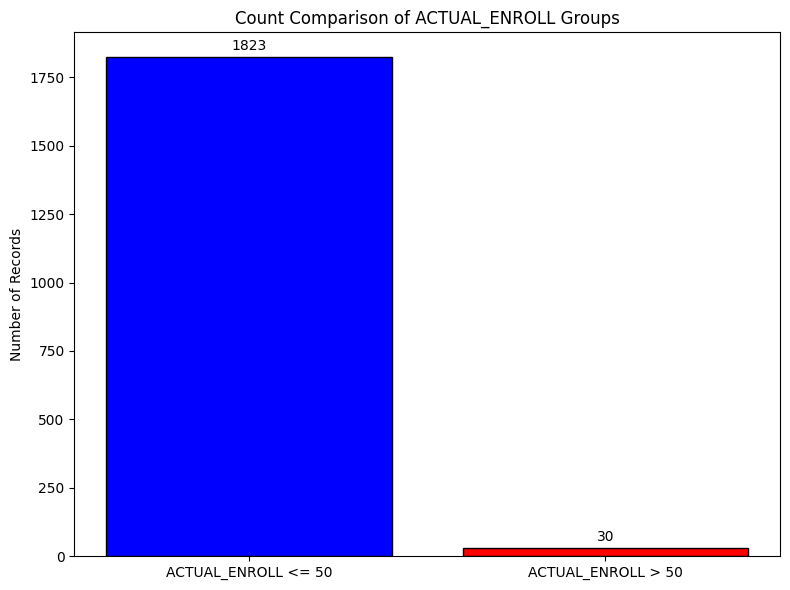

In [138]:
column_name =  'COURSE_NUMBER'
bins = 30
threshold = 50
plot_enroll_comparison(ml_dataset, threshold=threshold, bins=bins, label_rotation=0)

In [139]:
enrollment_threshold= 50
high_enroll_df = ml_dataset[ml_dataset['ACTUAL_ENROLL'] > enrollment_threshold]

# Extract unique course numbers
course_numbers = high_enroll_df['COURSE_NUMBER'].unique()

print(f"Courses with ACTUAL_ENROLL < {enrollment_threshold}:")
for course in course_numbers:
    print(course)

Courses with ACTUAL_ENROLL < 50:
463
491
492
495
493


## IV. Training and evaluating

#### a. Break the original dataset to small quarterly dataset
The data set first divide into many small data set by term and year.
Then we randomly pick 4 quarter out as test set. And one the other remainning later is going to use in training and evaluation process.

In [114]:
import os
import random
# Create the folder 'data' if it does not exist
if not os.path.exists('data'):
    os.makedirs('data')

# Assuming ml_dataset is already defined
data = ml_dataset

# Split by Quarters
Summer = data[data['TERM_Summer'] == True]
Spring = data[data['TERM_Spring'] == True]
Winter = data[data['TERM_Winter'] == True]
Fall   = data[data['TERM_Fall']   == True]

fallandWinter = data[
    (data['TERM_Fall'] == True) | (data['TERM_Winter'] == True)
]

fallandSpring = data[
    (data['TERM_Fall'] == True) | (data['TERM_Spring'] == True)
]

winterandSpring = data[
    (data['TERM_Winter'] == True) | (data['TERM_Spring'] == True)
]

winterandSummer = data[
    (data['TERM_Winter'] == True) | (data['TERM_Summer'] == True)
]

fallandSummer = data[
    (data['TERM_Fall'] == True) | (data['TERM_Summer'] == True)
]

springandSummer = data[
    (data['TERM_Spring'] == True) | (data['TERM_Summer'] == True)
]

fallandWinterandSpring = data[
    (data['TERM_Winter'] == True) | (data['TERM_Spring'] == True) | (data['TERM_Fall'] == True)
]

fallandWinterandSummer = data[
    (data['TERM_Winter'] == True) | (data['TERM_Summer'] == True) | (data['TERM_Fall'] == True)
]

fallandSummerandSpring = data[
    (data['TERM_Summer'] == True) | (data['TERM_Spring'] == True) | (data['TERM_Fall'] == True)
]

SummerandWinterandSpring = data[
    (data['TERM_Winter'] == True) | (data['TERM_Spring'] == True) | (data['TERM_Summer'] == True)
]

# Save each DataFrame as CSV in the 'data' folder
fallandWinter.to_csv('data/fall-winter.csv', index=False)
fallandSpring.to_csv('data/fall-Spring.csv', index=False)
winterandSpring.to_csv('data/winter-spring.csv', index=False)
winterandSummer.to_csv('data/winter-summer.csv', index=False)
fallandSummer.to_csv('data/fall-summer.csv', index=True)
springandSummer.to_csv('data/spring-summer.csv', index=False)
fallandWinterandSpring.to_csv('data/fall-winter-spring.csv', index=False)
fallandWinterandSummer.to_csv('data/fall-winter-summer.csv', index=False)
fallandSummerandSpring.to_csv('data/fall-summer-spring.csv', index=False)
SummerandWinterandSpring.to_csv('data/summer-winter-spring.csv', index=False)

Summer.to_csv('data/summer.csv', index=False)
Spring.to_csv('data/spring.csv', index=False)
Winter.to_csv('data/winter.csv', index=False)
Fall.to_csv('data/fall.csv', index=False)

# Split by both Quarter and Year
terms = ['Winter', 'Spring', 'Summer', 'Fall']
years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

for year in years:
    for term in terms:
        term_key = f'TERM_{term}'
        year_key = f'YEAR_{year}'
        filtered_data = data[(data[term_key] == True) & (data[year_key] == True)]
        # Save each file with a two-letter term code and the last two digits of the year
        filtered_data.to_csv(f'data/{term[:2].upper()}{year % 100}.csv', index=False)


quarters = [
    'data/FA14.csv', 'data/WI15.csv', 'data/SP15.csv', 'data/SU15.csv',
    'data/FA15.csv', 'data/WI16.csv', 'data/SU16.csv', 'data/FA16.csv',
    'data/WI17.csv', 'data/SP17.csv', 'data/SU17.csv', 'data/FA17.csv',
    'data/WI18.csv', 'data/SP18.csv', 'data/SU18.csv', 'data/FA18.csv',
    'data/WI19.csv', 'data/SP19.csv', 'data/SU19.csv', 'data/FA19.csv',
    'data/WI20.csv', 'data/SP20.csv', 'data/SU20.csv', 'data/FA20.csv',
    'data/WI21.csv', 'data/SP21.csv', 'data/SU21.csv', 'data/FA21.csv',
    'data/WI22.csv', 'data/SP22.csv', 'data/SU22.csv', 'data/FA22.csv',
    'data/WI23.csv', 'data/SP23.csv', 'data/SU23.csv', 'data/FA23.csv',
    'data/WI24.csv', 'data/SP24.csv'
]

# For reproducibility, set a seed (optional)
random.seed(42)

# Randomly choose 4 quarters for the test set
test_quarters = random.sample(quarters, 4)

# The remaining quarters will be used for training
train_quarters = [q for q in quarters if q not in test_quarters]

print("Test Quarters:", test_quarters)
print("Train Quarters:", train_quarters)

quarter = train_quarters
# Merge the test set CSV files
merged_test_set = pd.concat([pd.read_csv(file) for file in test_quarters], ignore_index=True)
merged_test_set.to_csv('data/randomized_test_set.csv', index=False)
merged_test_set
test_x, test_y = torch.tensor(merged_test_set.drop(columns=['ACTUAL_ENROLL']).to_numpy(dtype=np.float32)), torch.tensor(merged_test_set["ACTUAL_ENROLL"].to_numpy(dtype=np.float32))

# make a copy for training Scikitlearn model
scikitlearn_quarter = quarter.copy()
scikitlearn_test_quarter = test_quarters.copy()

Test Quarters: ['data/FA16.csv', 'data/WI15.csv', 'data/SP19.csv', 'data/FA18.csv']
Train Quarters: ['data/FA14.csv', 'data/SP15.csv', 'data/SU15.csv', 'data/FA15.csv', 'data/WI16.csv', 'data/SU16.csv', 'data/WI17.csv', 'data/SP17.csv', 'data/SU17.csv', 'data/FA17.csv', 'data/WI18.csv', 'data/SP18.csv', 'data/SU18.csv', 'data/WI19.csv', 'data/SU19.csv', 'data/FA19.csv', 'data/WI20.csv', 'data/SP20.csv', 'data/SU20.csv', 'data/FA20.csv', 'data/WI21.csv', 'data/SP21.csv', 'data/SU21.csv', 'data/FA21.csv', 'data/WI22.csv', 'data/SP22.csv', 'data/SU22.csv', 'data/FA22.csv', 'data/WI23.csv', 'data/SP23.csv', 'data/SU23.csv', 'data/FA23.csv', 'data/WI24.csv', 'data/SP24.csv']


### b. Training, evaluate and test
**Idea**: Making smaller data set for each quarter.
We can train on some quarter then test on some quarter. We leave one test set out. Then iterate by cross validation

#### i. Deep neural network with pytorch
**Hyper parameter** after training
*   Learning rate: 0.08
*   Numlayer : 3
*   Num unit per layer: 60
*   MB size: 8
*   Patient: 50
*   Epoch: 200
*   Drop out: 0.1
*   Hidden activation: Relu


##### i.a. Some helper method

*   get_data: k-folder go up by quarter each time. we need this helper to conca the datapoint exactly between train and dev
*   r2_score: just calculate the accuary





In [115]:
# random.shuffle(quarters)
def get_data(leave_out_quarters):
    train_files = [file for file in quarters if file not in leave_out_quarters]
    train_set = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)
    dev_set = pd.concat([pd.read_csv(file) for file in leave_out_quarters], ignore_index=True)

    train_x, train_y = torch.tensor(train_set.drop(columns=['ACTUAL_ENROLL']).to_numpy(dtype=np.float32)), torch.tensor(train_set["ACTUAL_ENROLL"].to_numpy(dtype=np.float32))
    dev_x, dev_y = torch.tensor(dev_set.drop(columns=['ACTUAL_ENROLL']).to_numpy(dtype=np.float32)), torch.tensor(dev_set["ACTUAL_ENROLL"].to_numpy(dtype=np.float32))

    return train_x, train_y, dev_x, dev_y

def r2_score(y_true, y_pred):
    y_true_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_true_mean) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)



##### i.b. Model implementation
Deep learning model with init, forward passs and predict method

In [116]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(RegressionNN, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [1]
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            for i in range(len(layer_sizes) - 1)
        ])
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
            x = self.dropout(x)
        return self.layers[-1](x)

    def predict(self, x):
        # Set the model to evaluation mode
        self.eval()
        # Disable gradient computation for inference
        with torch.no_grad():
            predictions = self.forward(x)
        return predictions


##### i.c. Early stopping implementation
Stop training the model when the performance on dev set does not improve.
Patience: Control how long we going to stop training after the performance does not improve.
save_path: save the best model that achieve the best score.

In [117]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=True, save_path="checkpoint.pth"):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.save_path, self.counter, self.best_score, self.early_stop = save_path, 0, None, False

    def __call__(self, validation_loss, model):
        score = -validation_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(validation_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(validation_loss, model)
            self.counter = 0

    def save_checkpoint(self, validation_loss, model):
        if self.verbose:
            print(f"Validation loss decreased. Saving model...")
        torch.save(model.state_dict(), self.save_path)

##### i.d. Train for a single fold implematation
For a single train and dev data set we can train for each fold

In [118]:
def train_and_evaluate(train_x, train_y, dev_x, dev_y, test_x, test_y,
                       input_size, hidden_sizes, learning_rate, batch_size,
                       num_epochs=200, patience=50, fold_name=""):
    # Prepare data loaders
    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(TensorDataset(dev_x, dev_y), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batch_size, shuffle=False)

    # Create model, loss criterion and optimizer
    model = RegressionNN(input_size, hidden_sizes)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set unique save path for the fold's best model
    save_path = f"best_model_{fold_name}.pth"
    early_stopping = EarlyStopping(patience=patience, save_path=save_path, verbose=False)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x).squeeze(1)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)

        # Evaluate on the dev set
        model.eval()
        with torch.no_grad():
            val_losses = []
            for val_x, val_y in dev_loader:
                val_outputs = model(val_x).squeeze(1)
                val_loss = criterion(val_outputs, val_y)
                val_losses.append(val_loss.item())
            avg_val_loss = sum(val_losses) / len(val_losses)

        # Uncomment for progress logging
        # print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model saved during training
    model.load_state_dict(torch.load(save_path))
    model.eval()

    # Evaluate on dev set for final metrics (optional)
    with torch.no_grad():
        all_val_outputs, all_val_targets = [], []
        for val_x, val_y in dev_loader:
            val_outputs = model(val_x).squeeze(1)
            all_val_outputs.append(val_outputs)
            all_val_targets.append(val_y)
        all_val_outputs = torch.cat(all_val_outputs)
        all_val_targets = torch.cat(all_val_targets)
        best_val_r2 = r2_score(all_val_targets, all_val_outputs).item()

    # Evaluate on the test set
    with torch.no_grad():
        all_test_outputs, all_test_targets = [], []
        for test_batch_x, test_batch_y in test_loader:
            test_outputs = model(test_batch_x).squeeze(1)
            all_test_outputs.append(test_outputs)
            all_test_targets.append(test_batch_y)
        all_test_outputs = torch.cat(all_test_outputs)
        all_test_targets = torch.cat(all_test_targets)
        test_loss = criterion(all_test_outputs, all_test_targets).item()
        test_r2 = r2_score(all_test_targets, all_test_outputs).item()

    return avg_val_loss, best_val_r2, test_loss, test_r2


##### i.e. Training and evaluating with 10 fold .
By iterating through fold, call the method train each fold and storing the required scores.

In [119]:
# Initialize lists to store metrics per fold.
results = []
dev_r2_scores = []
dev_rmse_scores = []
test_r2_scores = []
test_rmse_scores = []
fold_indices = []

for i in range(0, len(quarters), 4):
    if i + 4 > len(quarters):
        break

    leave_out_quarters = quarters[i:i+4]
    # Create a fold name by joining quarter names
    fold_name = "_".join([q.replace("data/", "").replace(".csv", "") for q in leave_out_quarters])
    fold_indices.append(fold_name)

    print(f"Leaving out: {', '.join(leave_out_quarters)}")

    # Assume get_data returns train and dev sets for the given quarters.
    train_x, train_y, dev_x, dev_y = get_data(leave_out_quarters)


    dev_loss, dev_r2, test_loss, test_r2 = train_and_evaluate(
        train_x, train_y, dev_x, dev_y, test_x, test_y,
        input_size=train_x.shape[1],
        hidden_sizes=[60, 60, 60],
        learning_rate=0.001,
        batch_size=8,
        fold_name=fold_name
    )


    dev_r2_scores.append(dev_r2)
    dev_rmse_scores.append(dev_loss ** 0.5)


    test_r2_scores.append(test_r2)
    test_rmse_scores.append(test_loss ** 0.5)

    results.append({
        'removed_quarters': fold_name,
        'dev_loss': dev_loss,
        'dev_r2_score': dev_r2,
        'test_loss': test_loss,
        'test_r2_score': test_r2
    })

print(f'Average Dev R² Score across folds: {sum(dev_r2_scores) / len(dev_r2_scores):.2f}')
print(f'Average Test R² Score across folds: {sum(test_r2_scores) / len(test_r2_scores):.2f}')


Leaving out: data/FA14.csv, data/WI15.csv, data/SP15.csv, data/SU15.csv
Early stopping triggered
Leaving out: data/FA15.csv, data/WI16.csv, data/SU16.csv, data/FA16.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Early stopping triggered
Leaving out: data/WI17.csv, data/SP17.csv, data/SU17.csv, data/FA17.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
<ipython-input-118-c38cffb14420>:51: FutureWa

Leaving out: data/WI18.csv, data/SP18.csv, data/SU18.csv, data/FA18.csv
Early stopping triggered
Leaving out: data/WI19.csv, data/SP19.csv, data/SU19.csv, data/FA19.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Early stopping triggered
Leaving out: data/WI20.csv, data/SP20.csv, data/SU20.csv, data/FA20.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Early stopping triggered
Leaving out: data/WI21.csv, data/SP21.csv, data/SU21.csv, data/FA21.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Early stopping triggered
Leaving out: data/WI22.csv, data/SP22.csv, data/SU22.csv, data/FA22.csv


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
<ipython-input-118-c38cffb14420>:51: FutureWa

Leaving out: data/WI23.csv, data/SP23.csv, data/SU23.csv, data/FA23.csv
Early stopping triggered
Average Dev R² Score across folds: 0.52
Average Test R² Score across folds: 0.63


<ipython-input-118-c38cffb14420>:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


##### i.f. Plotting R^2 through k-folder from dev set and test set

###### Plot Dev RMSE and R² Score per Fold

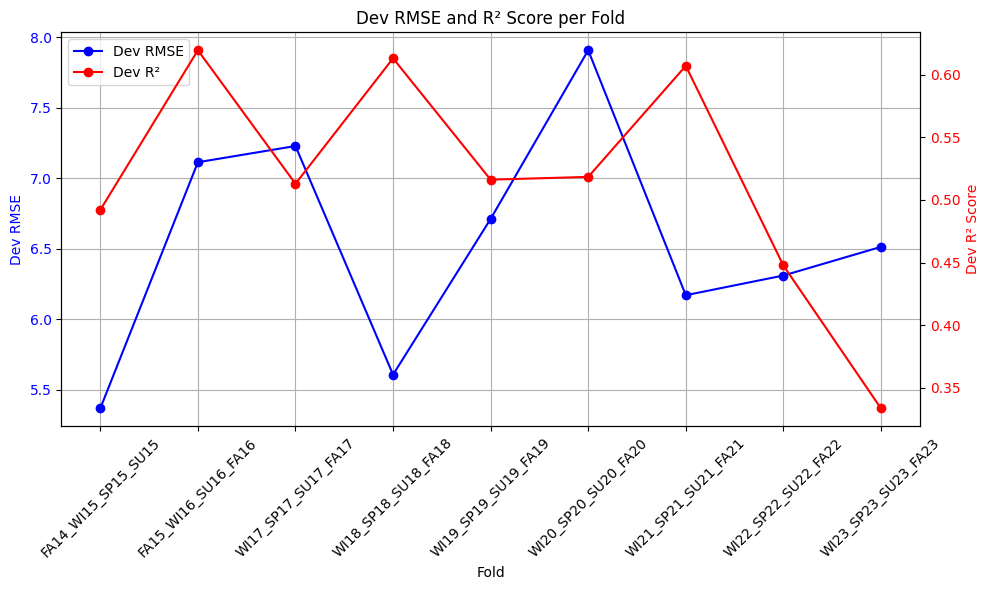

In [120]:
# Plot Dev metrics: RMSE and R² per fold.
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(fold_indices, dev_rmse_scores, marker='o', linestyle='-', color='b', label='Dev RMSE')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Dev RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Dev RMSE and R² Score per Fold')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fold_indices, dev_r2_scores, marker='o', linestyle='-', color='r', label='Dev R²')
ax2.set_ylabel('Dev R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.set_xticks(fold_indices)
ax1.set_xticklabels(fold_indices, rotation=45)
plt.tight_layout()
plt.show()

###### Plot test RMSE and R² Score per Fold

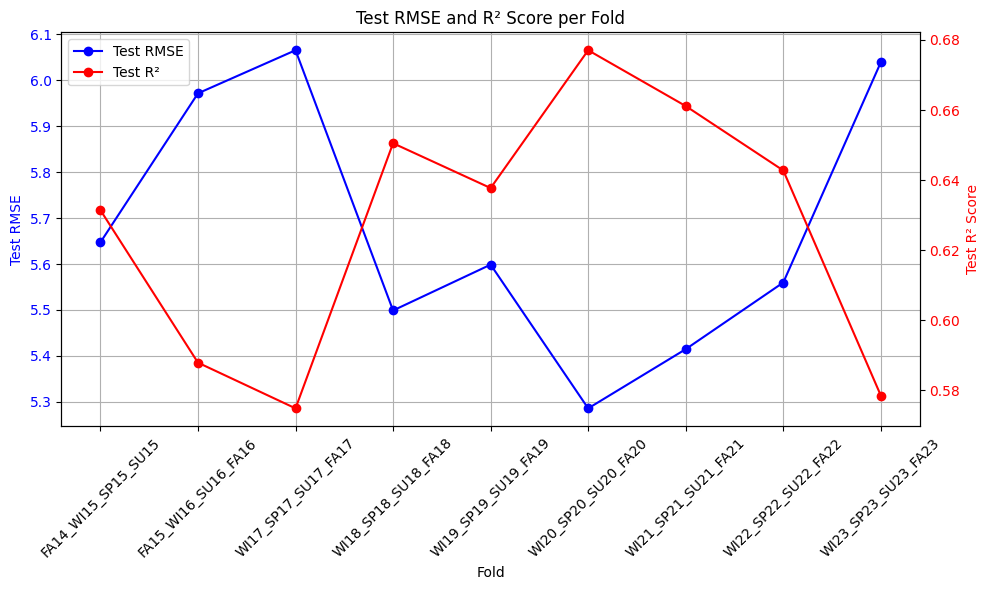

In [121]:
# Plot Test metrics: RMSE and R² per fold.
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(fold_indices, test_rmse_scores, marker='o', linestyle='-', color='b', label='Test RMSE')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Test RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Test RMSE and R² Score per Fold')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(fold_indices, test_r2_scores, marker='o', linestyle='-', color='r', label='Test R²')
ax2.set_ylabel('Test R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_xticks(fold_indices)
ax1.set_xticklabels(fold_indices, rotation=45)
plt.tight_layout()
plt.show()

#### ii. Deep neural network with Scikit learn

##### ii.a. Model

In [73]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
model = MLPRegressor(
    hidden_layer_sizes=(60, 60),
    activation='tanh',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    alpha=0.01,
    verbose=False
)


##### ii.b Trainning loop

In [87]:
def Scikitlearn_train_Kfold(model, train_files, test_files):
        # wandb.init(project="fold_validation", name="manually_chosing_quarter")

  r2_scores = []
  rmse_scores = []
  fold_indices = []
  test_preds_list = []  # Store test predictions from each fold

  for i in range(0, len(train_files), 4):
      if i + 4 > len(train_files):
          break  # Avoid incomplete folds

      # Define fold: use one file as validation and the rest as training.
      val_set = train_files[i:i+4]
      train_set = [file for file in train_files if file not in val_set]

      fold_name = ", ".join([file.replace("data/", "").replace(".csv", "") for file in val_set])
      fold_indices.append(fold_name)

      # Load training and validation data.
      merged_train_set = pd.concat([pd.read_csv(file) for file in train_set], ignore_index=True)
      merged_val_set = pd.concat([pd.read_csv(file) for file in val_set], ignore_index=True)

      # Separate features and target for training and validation.
      y_train = merged_train_set['ACTUAL_ENROLL']
      X_train = merged_train_set.drop(columns=['ACTUAL_ENROLL'])

      y_val = merged_val_set['ACTUAL_ENROLL']
      X_val = merged_val_set.drop(columns=['ACTUAL_ENROLL'])

      print(f"Fold {i+1} - Removed Quarters: {fold_name}")
      print(f"Training Shape: {X_train.shape}, Validation Shape: {X_val.shape}")

      # Train model on training set.
      model.fit(X_train, y_train)
      y_pred_val = model.predict(X_val)

      # Compute validation metrics.
      rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
      r2_val = r2_score(y_val, y_pred_val)

      print(f'Validation RMSE: {rmse_val:.2f}')
      print(f'R² Score: {r2_val:.2f}\n')

      rmse_scores.append(rmse_val)
      r2_scores.append(r2_val)
      # wandb.log({"fold": i+1, "rmse": rmse_val, "r2": r2_val})

      # Load the merged test set (same for every fold) and predict.
      merged_test_set = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)
      y_test = merged_test_set['ACTUAL_ENROLL']
      X_test = merged_test_set.drop(columns=['ACTUAL_ENROLL'])

      y_pred_test = model.predict(X_test)
      test_preds_list.append(y_pred_test)

  # Average the test predictions across folds.
  test_preds_array = np.array(test_preds_list)  # shape: (n_folds, n_samples)
  avg_test_preds = np.mean(test_preds_array, axis=0)

  # Get the true test values (should be the same across folds).
  merged_test_set = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)
  y_test_true = merged_test_set['ACTUAL_ENROLL'].values

  print(f'Average Validation RMSE: {np.mean(rmse_scores):.2f}')
  print(f'Average Validation R² Score: {np.mean(r2_scores):.2f}')

  # wandb.finish()

  # Return a dictionary of results for external plotting.
  results_dict = {
      'fold_indices': fold_indices,
      'rmse_scores': rmse_scores,
      'r2_scores': r2_scores,
      'avg_test_preds': avg_test_preds,
      'y_test_true': y_test_true
  }
  return results_dict

##### iii.c Training and eveluate with 10 fold

In [78]:
results_dict = Scikitlearn_train_Kfold(model, scikitlearn_quarter, scikitlearn_test_quarter)

Fold 1 - Removed Quarters: FA14, SP15, SU15, FA15
Training Shape: (1400, 273), Validation Shape: (187, 273)
Validation RMSE: 5.59
R² Score: 0.53

Fold 5 - Removed Quarters: WI16, SU16, WI17, SP17
Training Shape: (1425, 273), Validation Shape: (162, 273)
Validation RMSE: 9.16
R² Score: 0.21

Fold 9 - Removed Quarters: SU17, FA17, WI18, SP18
Training Shape: (1377, 273), Validation Shape: (210, 273)
Validation RMSE: 6.99
R² Score: 0.31

Fold 13 - Removed Quarters: SU18, WI19, SU19, FA19
Training Shape: (1436, 273), Validation Shape: (151, 273)
Validation RMSE: 6.34
R² Score: 0.49

Fold 17 - Removed Quarters: WI20, SP20, SU20, FA20
Training Shape: (1408, 273), Validation Shape: (179, 273)
Validation RMSE: 8.66
R² Score: 0.41

Fold 21 - Removed Quarters: WI21, SP21, SU21, FA21
Training Shape: (1394, 273), Validation Shape: (193, 273)
Validation RMSE: 6.05
R² Score: 0.60

Fold 25 - Removed Quarters: WI22, SP22, SU22, FA22
Training Shape: (1392, 273), Validation Shape: (195, 273)
Validation R

##### iv. Plotting R^2 through k-folder from dev set and test set
First, taking out the different metric in result dictionary

In [100]:
skicit_fold_indices = results_dict['fold_indices']
skicit_rmse_scores = results_dict['rmse_scores']
skicit_r2_scores = results_dict['r2_scores']
skicit_avg_test_preds = results_dict['avg_test_preds']
skicit_y_test_true = results_dict['y_test_true']

###### Plot of dev RMSE and R² Score per Fold

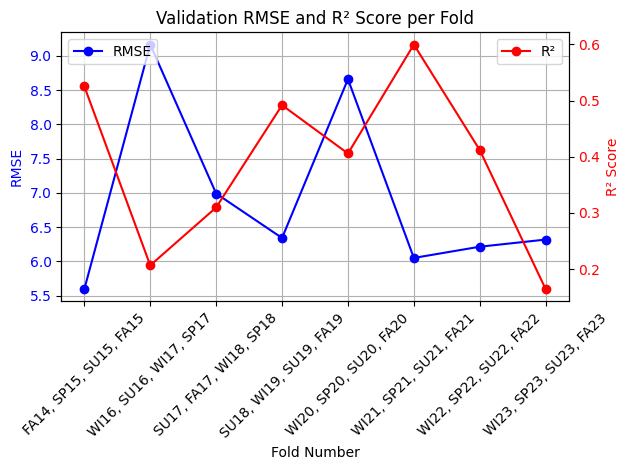

In [101]:
# Plot validation metrics per fold.
fig, ax1 = plt.subplots()
ax1.plot(skicit_fold_indices, skicit_rmse_scores, marker='o', label='RMSE', linestyle='-', color='b')
ax1.set_xlabel('Fold Number')
ax1.set_ylabel('RMSE', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Validation RMSE and R² Score per Fold')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(skicit_fold_indices, skicit_r2_scores, marker='o', label='R²', linestyle='-', color='r')
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_xticks(range(len(skicit_fold_indices)))
ax1.set_xticklabels(skicit_fold_indices, rotation=45)
plt.tight_layout()
plt.show()

###### Predicted vs ground true value on test set

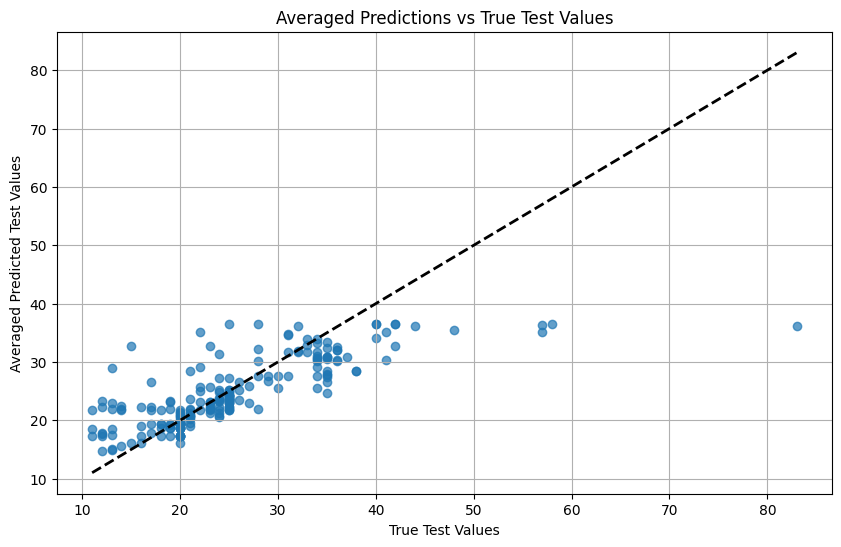

In [102]:
# Plot averaged test predictions vs true test values.
plt.figure(figsize=(10, 6))
plt.scatter(skicit_y_test_true, skicit_avg_test_preds, alpha=0.7)
plt.plot([skicit_y_test_true.min(), skicit_y_test_true.max()],
         [skicit_y_test_true.min(), skicit_y_test_true.max()], 'k--', lw=2)
plt.xlabel("True Test Values")
plt.ylabel("Averaged Predicted Test Values")
plt.title("Averaged Predictions vs True Test Values")
plt.grid(True)
plt.show()